In [1]:
from BenchmarkProblems.Trapk import Trapk
import numpy as np

from Core.get_pRef import get_pRef_from_metaheuristic
# Check that reference populations and metrics work as intended

from Core.FullSolution import FullSolution
from Core.PS import PS, contains, STAR
from BenchmarkProblems.RoyalRoad import RoyalRoad

# first, we make a benchmark problem
problem = RoyalRoad(4, 5)


# then we make a pRef
pRef = get_pRef_from_metaheuristic(problem=problem,
                                 sample_size=20000,
                                 which_algorithm="GA SA",
                                 unique=True,
                                 verbose=True)

print(f"The pRef is {pRef}")

starting [Running the algorithm to generate the PRef using GA]
[Running the algorithm to generate the PRef using GA]...Finished (took 0.764319 seconds)
starting [Running the algorithm to generate the PRef using SA]
[Running the algorithm to generate the PRef using SA]...Finished (took 1.403610 seconds)
The pRef is PRef with 3732 samples, mean = 3.56


In [2]:
from Core.PRef import PRef


def get_similar_pair_iterator(input_pRef: PRef):
    for index_a, row_a in enumerate(input_pRef.full_solution_matrix):
        for index_b, row_b in enumerate(input_pRef.full_solution_matrix[index_a+1:], start=index_a+1):
            diff_count = np.sum(row_a != row_b)
            if diff_count == 1:
                yield row_a, pRef.fitness_array[index_a], row_b, pRef.fitness_array[index_b]


In [7]:
from Core.SearchSpace import SearchSpace
import utils

# now we need to register the witnesses

# make a table, where the columns are
# diff_var, entire solution, outcome \in [win, loss, tie]
def make_witness_table(input_pRef):
    ss = input_pRef.search_space
    n = ss.amount_of_parameters
    
    entries = []
    def add_new_entry(diff_var, solution, fitness_own, fitness_other):
        outcome = np.sign(fitness_own - fitness_other)
        entries.append(np.hstack((diff_var, solution, outcome)))
        
    for sol_a, fit_a, sol_b, fit_b in get_similar_pair_iterator(input_pRef):
        diff_var = [index for index, val_a, val_b in zip(range(1000), sol_a, sol_b) if val_a != val_b][0]
        add_new_entry(diff_var, sol_a, fit_a, fit_b)
        if fit_a != fit_b:
            add_new_entry(diff_var, sol_b, fit_b, fit_a)
    
    return np.array(entries, dtype=int)

def get_linkage_table_from_witness_table(witness_table: np.ndarray, search_space: SearchSpace):
    n:int  = search_space.amount_of_parameters
    linkage_table = np.zeros(shape=(n, n), dtype=float)
    def entropy(values):
        distinct, counts = np.unique(values, return_counts=True)
        freqs = counts / len(values)
        return -np.sum(freqs * np.log2(freqs))
    
    def information_gain(original_values, partitioning):
        original_entropy = entropy(original_values)
        entropy_of_partitions = np.sum([entropy(partition) * len(partition)/len(original_values) 
                                        for partition in partitioning])
        return original_entropy - entropy_of_partitions
    
    def gain_ratio(original_values, partitioning):
        gained_info = information_gain(original_values, partitioning)
        sizes = np.array([len(partition) / len(original_values) for partition in partitioning])
        split_information = -np.sum(sizes * np.log2(sizes))
        return gained_info / split_information
            
    
    for var, cardinality in enumerate(search_space.cardinalities):
        #print(f"Processing var {var}")
        if cardinality < 2:
            continue
        rows_with_collect_var = witness_table[witness_table[:, 0]==var]
        for val in range(cardinality):
            rows_with_correct_val = rows_with_collect_var[rows_with_collect_var[:, var+1] == val]
            outcomes = rows_with_correct_val[:, -1]
            for witness_var in range(n):
                if search_space.cardinalities[witness_var] < 2:
                    continue
                # print(f"{var = }, {val = }, {witness_var =}")
                if witness_var == var:
                    continue
                partitioned_outcomes = [list() for _ in range(search_space.cardinalities[witness_var])]
                for outcome, witness_val in zip(outcomes, rows_with_correct_val[:, witness_var+1]):
                    #print(witness_val)
                    partitioned_outcomes[witness_val].append(outcome)
                
                #gained_info = information_gain(outcomes, partitioned_outcomes)
                gained_ratio = gain_ratio(outcomes, partitioned_outcomes)
                #linkage_table[var][witness_var]+=gained_ratio
                linkage_table[var][witness_var] = max(gained_ratio, linkage_table[var][witness_var])
    return linkage_table
    
# witness_table = make_witness_table(pRef)
# linkage_table=  get_linkage_table_from_witness_table(witness_table, pRef.search_space)
# 
# utils.show_matrix_with_colours(linkage_table, fig_size=(6, 6))
    
    

starting [Running the algorithm to generate the PRef using GA]
[Running the algorithm to generate the PRef using GA]...Finished (took 0.298528 seconds)
starting [Running the algorithm to generate the PRef using GA]
[Running the algorithm to generate the PRef using GA]...Finished (took 0.381329 seconds)
starting [Running the algorithm to generate the PRef using GA]
[Running the algorithm to generate the PRef using GA]...Finished (took 0.386289 seconds)
The optima was
[1 0 1 0]
[0 1 0 1]
[1 0 1 0]
[0 1 0 1]
Generating the witness table
Generating the linkage table


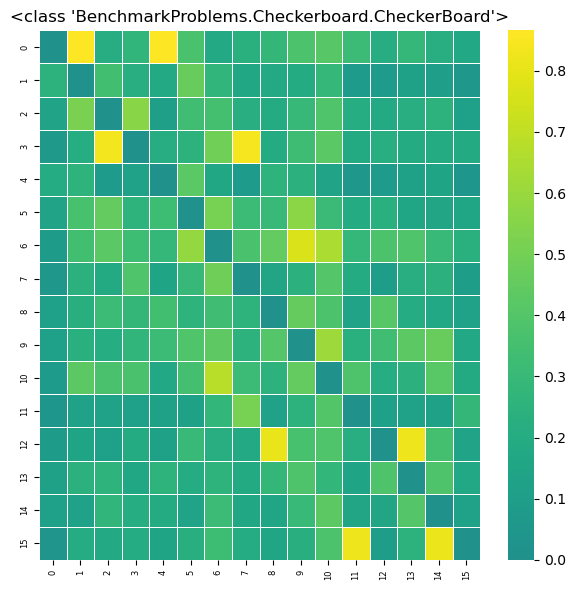

Max = 0.8662532344033754


In [11]:


from BenchmarkProblems.TwoPeaks import TwoPeaks
from BenchmarkProblems.BT.EfficientBTProblem.EfficientBTProblem import EfficientBTProblem
from initial_testing.understand_files.rearrange_linkage_table import clean_table
from BenchmarkProblems.GraphColouring import GraphColouring
from BenchmarkProblems.Checkerboard import CheckerBoard
from BenchmarkProblems.ParityProblem import ParityProblem
from BenchmarkProblems.RoyalRoadWithOverlaps import RoyalRoadWithOverlaps
from BenchmarkProblems.OneMax import OneMax

#problems = [RoyalRoad(5), Trapk(4, 5), OneMax(4, 5), RoyalRoadWithOverlaps(4, 5, 16), TwoPeaks(20), ParityProblem(4, 5), CheckerBoard(4, 4)]
problems = [CheckerBoard(4, 4)]
#problems = [GraphColouring.make_insular_instance(4)]
#problems = [EfficientBTProblem.from_default_files()]

for problem in problems:
    # then we make a pRef
    pRef = get_pRef_from_metaheuristic(problem=problem,
                                     sample_size=10000,
                                     which_algorithm="GA GA GA",
                                     unique=True,
                                     verbose=True)
    optima = pRef.get_best_solution()
    print(f"The optima was")
    print(problem.repr_fs(optima))
    
    print("Generating the witness table")
    witness_table = make_witness_table(pRef)
    print(f"Generating the linkage table")
    linkage_table=  get_linkage_table_from_witness_table(witness_table, pRef.search_space)

    utils.show_matrix_with_colours(linkage_table, fig_size=(6, 6), name=repr(type(problem)))
    #utils.show_matrix_with_colours(clean_table(linkage_table), fig_size=(6, 6), name=repr(type(problem))+"rearranged")
    print(f"Max = {np.max(linkage_table)}")
    
    

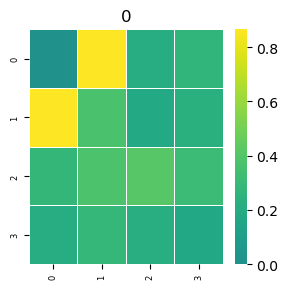

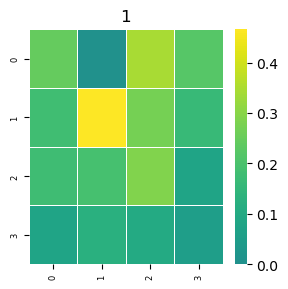

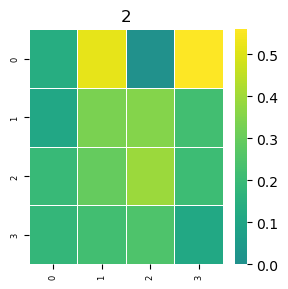

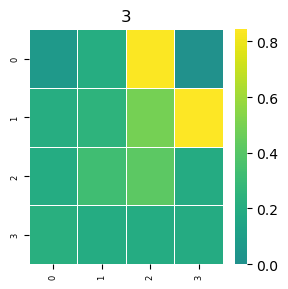

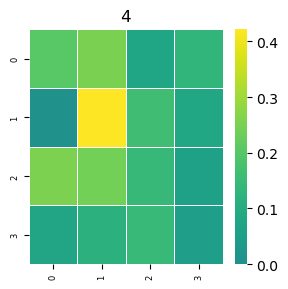

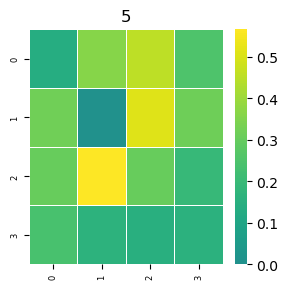

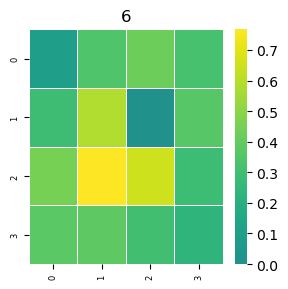

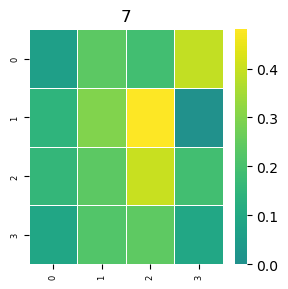

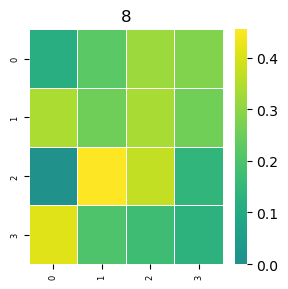

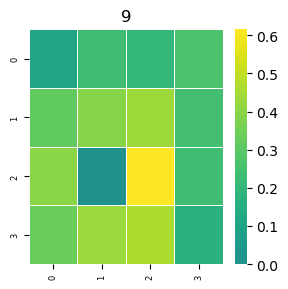

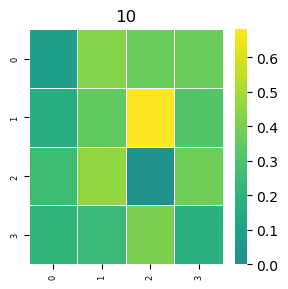

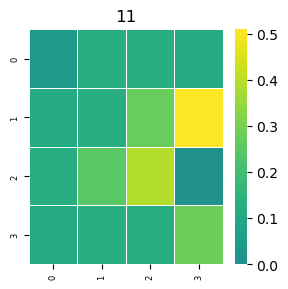

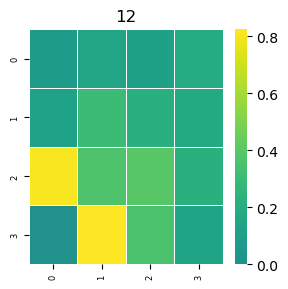

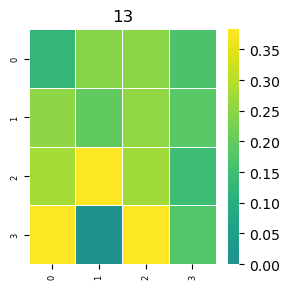

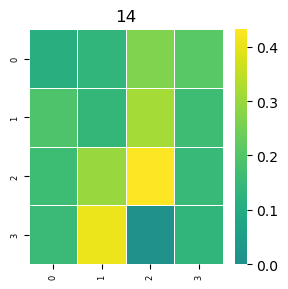

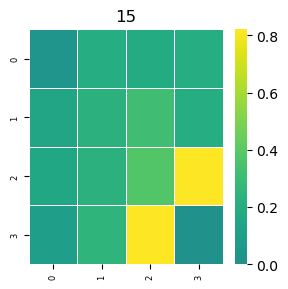

In [15]:
def show_row(row_index):
    row = linkage_table[row_index]
    utils.show_matrix_with_colours(row.reshape((4, 4)), fig_size=(3, 3), name=f"{row_index}")
    
for index in range(16):
    show_row(index)

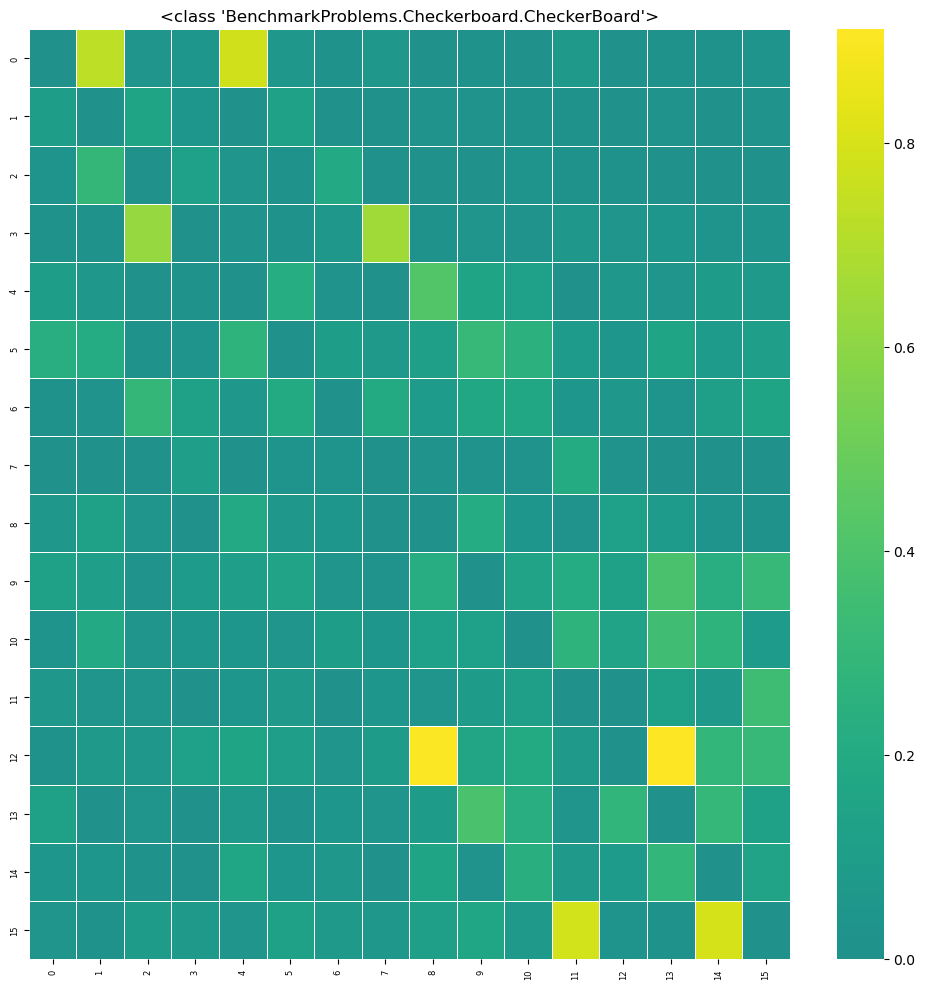

IndexError: index 16 is out of bounds for axis 0 with size 16

In [5]:
import os

corrected_linkage_table = linkage_table.copy()
corrected_linkage_table[np.isnan(corrected_linkage_table)] = 0

utils.show_matrix_with_colours(corrected_linkage_table, fig_size=(10, 10), name=repr(type(problem)))


def row_or_col_is_interesting(index):
    cardinality = pRef.search_space.cardinalities[index]
    if cardinality < 2:
        return False
    max_of_row_is_enough = np.max(corrected_linkage_table[index]) > 0.4
    max_of_col_is_enough = np.max(corrected_linkage_table[:, index]) > 0.4
    return max_of_row_is_enough or max_of_col_is_enough


def get_interst_in_index(index):
    sum_of_row = np.sum(corrected_linkage_table[index])
    sum_of_col = np.sum(corrected_linkage_table[:, index])
    return sum_of_row + sum_of_col

bt_problem = problems[0]
n = bt_problem.search_space.amount_of_parameters

sorted_indices = sorted(range(n), key=get_interst_in_index, reverse=True)
sorted_indices = sorted_indices[:90]
   

corrected_linkage_table = corrected_linkage_table[sorted_indices, :][:, sorted_indices]



utils.show_matrix_with_colours(corrected_linkage_table, fig_size=(10, 10), name=repr(type(problem)))
cleaned_table = clean_table(corrected_linkage_table)
utils.show_matrix_with_colours(cleaned_table, fig_size=(10, 10), name=repr(type(problem)) + "rearranged")

path = r"C:\Users\gac8\PycharmProjects\PSSearch\DetectingAnnoyingEffects"
np.savetxt(os.path.join(path, "table.csv"), cleaned_table, delimiter = ", ")

In [ ]:
import random
import utils
import numpy as np
def rearrange_table(table, new_order):
    return table[new_order, :][:, new_order]


def find_cleaner_arrangement_with_restriction(table, start_from):
    remaining_rows = list(range(table.shape[0]))

    picked_rows = [start_from]
    remaining_rows.remove(start_from)

    def get_distance_between_rows(row_a, row_b):
        return np.sum(np.abs(table[row_a] - table[row_b]))

    def distance_from_last_row(row):
        return get_distance_between_rows(row, picked_rows[-1])

    while (remaining_rows):
        picked = min(remaining_rows, key=distance_from_last_row)
        picked_rows.append(picked)
        remaining_rows.remove(picked)

    total_penalty = sum(get_distance_between_rows(a, b) for a, b in zip(picked_rows, picked_rows[1:] + [start_from]))

    return picked_rows, total_penalty


def select_best_arrangement_from_many(table):
    all_arrangements = [find_cleaner_arrangement_with_restriction(table, start) for start in range(table.shape[0])]

    best = min(all_arrangements, key=utils.second)
    return best[0]


def get_quality_of_rearrangement(original, rearrangement):
    rearranged = rearrange_table(original, rearrangement)
    
    diff_between_rows = np.sum([np.abs(row_before - row_after) for row_before, row_after in zip(rearranged, rearranged[1:])])
    diff_between_cols = np.sum([np.abs(row_before - row_after) for row_before, row_after in zip(rearranged.T, rearranged.T[1:])])
    return diff_between_rows + diff_between_cols

def get_random_rearrangement(table):
    n = table.shape[0]
    remaining_rows = list(range(n))

    return random.sample(remaining_rows, k=n)

def clean_table_slow(table, attempts = 1000):
    def quality(rearr):
        return get_quality_of_rearrangement(table, rearr)
    best_rearrangement = min((get_random_rearrangement(table) for _ in range(attempts)),key=quality)
    return rearrange_table(table, best_rearrangement)

In [ ]:
a = 50
some_table = np.zeros((a, a), dtype=int)
for x in range(a):
    for y in range(a):
        some_table[x, y] = abs((a / 2) - x) + abs((a / 2) - y)
        
scramble = random.sample(list(range(a)), k=a)
some_table = rearrange_table(some_table, scramble)

utils.show_matrix_with_colours(clean_table(clean_table_slow(corrected_linkage_table)), fig_size=(10, 10), name=repr(type(problem))+"rearranged")
# utils.show_matrix_with_colours(clean_table_slow(corrected_linkage_table, attempts=1000), fig_size=(10, 10), name=repr(type(problem))+"rearranged")